In [10]:
import copy, getpass, queue, random, sys, time, tqdm
import numpy as np
import torch
from torchvision.transforms import *

sys.path.append('../..')
from DL.utils import *
from DL.networks import *
from DL.sqlite_data_loader import SQLDataLoader
from Database.DB_models import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook
# matplotlib.use('GTK')
# import ipywidgets as wdg

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


In [25]:
EMBEDDING_MODEL = '/home/lynx/pretrainedmodels/embedding_triplet_resnet50_1499/triplet_resnet50_1499.tar'
CROP_DIR = '/datadrive/missouricameratraps/crops_detector/'
DB_LIMIT = 2000

In [26]:
# Load the pretrained embedding model
checkpoint = load_checkpoint(EMBEDDING_MODEL)
if checkpoint['loss_type'].lower() == 'center' or checkpoint['loss_type'].lower() == 'softmax':
    embedding_net = SoftmaxNet(checkpoint['arch'], checkpoint['feat_dim'], False)
else:
    embedding_net = NormalizedEmbeddingNet(checkpoint['arch'], checkpoint['feat_dim'], False)
model = torch.nn.DataParallel(embedding_net).cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()


DataParallel(
  (module): NormalizedEmbeddingNet(
    (inner_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [27]:
DB_NAME = getpass.getpass('Enter database name:')
DB_USER = getpass.getpass('Enter username for database:')
DB_PASSWORD = getpass.getpass('Enter password for database user:')

Enter database name:········
Enter username for database:········
Enter password for database user:········


In [28]:
target_db = PostgresqlDatabase(DB_NAME, user=DB_USER, password=DB_PASSWORD, host='localhost')
target_db.connect(reuse_if_open=True)
db_proxy.initialize(target_db)
dataset_query = Detection.select(Detection.image_id, Oracle.label, Detection.kind).join(Oracle).limit(DB_LIMIT)
dataset = SQLDataLoader(CROP_DIR, query=dataset_query, is_training=False, kind=DetectionKind.ModelDetection.value, num_workers=8, limit=DB_LIMIT)
dataset.updateEmbedding(model)
sample_ids = [s[0] for s in dataset.samples]
imagepaths = dataset.getallpaths()

Reading database to get samples.
[0, 1957, 7, 36, 43]
Load dataset mean and std from database
Extracting embedding from the provided model ...
Batch 0
Embedding extraction is done.


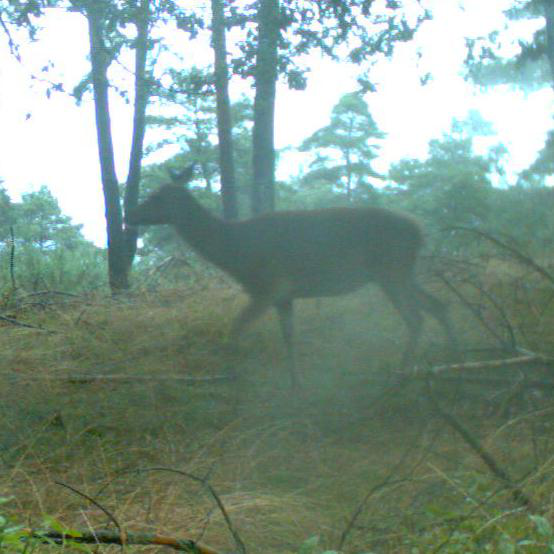

In [29]:
query_idx = np.random.randint(len(dataset.samples))
query_img = dataset.loader(imagepaths[query_idx].split('.')[0])
query_img

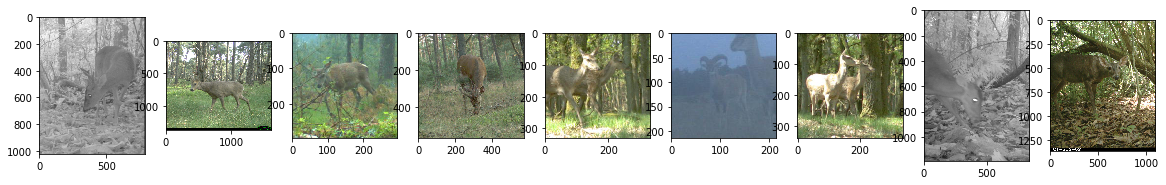

In [31]:
nbrs = NearestNeighbors(n_neighbors=11).fit(dataset.em)
distances, indices = nbrs.kneighbors(dataset.em)
query_nbrs_indices = indices[query_idx, 1:10]
plt.figure(figsize=(20, 12))
for i in range(len(query_nbrs_indices)):
    nbr_idx = query_nbrs_indices[i]
#     print(nbr_idx)
    nbr_img = dataset.loader(imagepaths[nbr_idx].split('.')[0])
    plt.subplot(1,len(query_nbrs_indices), i+1)
    plt.imshow(nbr_img)
# #     nbr_img.save("embedding_nnbr_img%d.png"%i)

In [6]:
# Access the inner ResNet
model_inner_resnet = list(model.children())[0].inner_model
# model_inner_resnet.eval() # not sure if this is necessary

In [7]:
def get_layer_outputs_by_forward_hook(model, model_layer, input_sample_ids, dataset):
    # Create a hook function to store layer outputs
    layer_outputs = []
    def hook_function(module, input, output):
        layer_outputs.append(output)
    
    # Register the hook
    hook_handle = model_layer.register_forward_hook(hook_function)
    
    # Get output of layer for input samples
    dataset.image_mode()
    with torch.no_grad():
        for isid in tqdm.tqdm(input_sample_ids):
            img = dataset.loader(isid)
            img_tensor = dataset.eval_transform(img)
            output = model.forward(img_tensor.unsqueeze(0))
    
    # Deregister the hook
    hook_handle.remove()
    
    return layer_outputs

In [ ]:
l3b1conv1_outputs = get_layer_outputs_by_forward_hook(model, model_inner_resnet.layer3[0].conv1, sample_ids, dataset)

In [ ]:
l4b1conv1_outputs = get_layer_outputs_by_forward_hook(model, model_inner_resnet.layer4[0].conv1, sample_ids, dataset)

In [ ]:
class PQItem:
    def __init__(self, euc_dist, idx, act_vec):
        self.euc_dist = euc_dist
        self.idx = idx
        self.act_vec = act_vec
    
    def __lt__(self, other):
        return self.euc_dist < other.euc_dist

In [ ]:
print(l4b1conv1_outputs[0].shape)

In [ ]:
## Possibly interesting channels
441 # snouts/eyes?
152 # speckles/light spots on dark background?

In [ ]:
# What do the channels in the network see?
# # For a given channel, store the images with highest activation in that channel
channel_no = 264#random.sample(range(l4b1conv1_outputs[0].shape[1]), 1)[0]
pq = queue.PriorityQueue()

for idx in range(len(l4b1conv1_outputs)):
    im_activation_maps = l4b1conv1_outputs[idx]
    im_channel_activation_map = im_activation_maps[0,channel_no,:,:].cpu().detach().numpy()
    max_activation_pos = np.unravel_index(np.argmax(im_channel_activation_map, axis=None), im_channel_activation_map.shape)
    max_activation = im_channel_activation_map[max_activation_pos]
    pqitem = PQItem(-max_activation, idx, (im_channel_activation_map, max_activation_pos))
    pq.put(pqitem)

dataset.image_mode()

plt.subplots(figsize=(12,40))
k = 10

for i in range(k):
    max_activating_img_data = pq.get()
    max_activating_img = dataset.loader(sample_ids[max_activating_img_data.idx])
    plt.subplot(k,2,i*2+1)
    plt.imshow(np.asarray(max_activating_img))
    plt.subplot(k,2,i*2+2)
    plt.imshow(max_activating_img_data.act_vec[0][:,:])


In [ ]:
print(channel_no)

In [ ]:
query_sid = random.sample(sample_ids, 1)[0]
query_sid_idx = sample_ids.index(query_sid)

# random_sid_idx = 0
# random_sid = sample_ids[random_sid_idx]

# Visualize the random sample image to use as query image
dataset.image_mode()
query_img = dataset.loader(query_sid)
query_img_tensor = dataset.eval_transform(query_img)
print(query_img_tensor.shape)
plt.subplot(1,2,1)
plt.imshow(np.asarray(query_img))
plt.subplot(1,2,2)
plt.imshow(np.asarray(ToPILImage()(query_img_tensor)))

In [ ]:
def visualize_channel_activations(img_layer_output, channels_to_vis):
    n_channels_to_vis = len(channels_to_vis)
    fig, axs = plt.subplots(figsize=(23,30))
    for i in range(n_channels_to_vis):
        plt.subplot(1,n_channels_to_vis,i+1)
        channel_no = channels_to_vis[i]
        plt.imshow(img_layer_output[0,channel_no,:,:], cmap='viridis')
        plt.title(str(channel_no))    

In [ ]:
query_img_layer_output = l3b1conv1_outputs[query_sid_idx].cpu().detach().numpy()
rand_channels_to_vis = random.sample(range(query_img_layer_output.shape[1]), 5)
visualize_channel_activations(query_img_layer_output, rand_channels_to_vis)

In [ ]:
query_img_layer_output = l4b1conv1_outputs[query_sid_idx].cpu().detach().numpy()
rand_channels_to_vis = random.sample(range(query_img_layer_output.shape[1]), 5)
visualize_channel_activations(query_img_layer_output, rand_channels_to_vis)

In [ ]:
def find_images_with_similar_activations(layer_outputs, query_sid_idx, position, padding, k=5):
    query_img_layer_output = layer_outputs[query_sid_idx].cpu().detach().numpy()
    query_activations_at_pos = query_img_layer_output[0, :, position[0], position[1]]
    
    pq = queue.PriorityQueue()
    
    for imidx in tqdm.tqdm(range(len(sample_ids))):
        if imidx == query_sid_idx:
            continue
        img_layer_output = layer_outputs[imidx].cpu().detach().numpy()
        # Iterate over positions in padding region
        ymin = max(position[0] - padding, 0)
        ymax = min(position[0] + padding, query_img_layer_output.shape[2]-1)
        xmin = max(position[1] - padding, 0)
        xmax = min(position[1] + padding, query_img_layer_output.shape[3]-1)
        for y in range(ymin, ymax+1):
            for x in range(xmin, xmax+1):
                activations_at_pos = img_layer_output[0, :, y, x]
                edist = np.linalg.norm(activations_at_pos - query_activations_at_pos)
                pqitem = PQItem(edist, imidx, activations_at_pos)
                pq.put(pqitem)

    closest_k_idx = []
    closest_k_edist = []
    while len(closest_k_idx) < k:
        next_pqitem = pq.get()
        if next_pqitem.idx in closest_k_idx:
            continue
        else:
            closest_k_idx.append(next_pqitem.idx)
            closest_k_edist.append(next_pqitem.euc_dist)
#     print(closest_k_edist)
    
    return closest_k_idx


In [ ]:
k = 5
closest_k_layer3 = find_images_with_similar_activations(l3b1conv1_outputs, query_sid_idx, (11,12), 5, k)
closest_k_layer4 = find_images_with_similar_activations(l4b1conv1_outputs, query_sid_idx, (5,5), 2, k)

In [ ]:
plt.figure(figsize=(10, 20))
for i in range(k):
    min_edist_sid = sample_ids[closest_k_layer3[i]]
    # Visualize the image
    dataset.image_mode()
    min_edist_img = dataset.loader(min_edist_sid)
    min_edist_img_tensor = dataset.eval_transform(min_edist_img)
    plt.subplot(k,2,i*2 + 1)
    plt.imshow(np.asarray(min_edist_img))
    plt.subplot(k,2,i*2 + 2)
    plt.imshow(np.asarray(ToPILImage()(min_edist_img_tensor)))

In [ ]:
plt.figure(figsize=(10, 20))
for i in range(k):
    min_edist_sid = sample_ids[closest_k_layer4[i]]
    # Visualize the image
    dataset.image_mode()
    min_edist_img = dataset.loader(min_edist_sid)
    min_edist_img_tensor = dataset.eval_transform(min_edist_img)
    plt.subplot(k,2,i*2 + 1)
    plt.imshow(np.asarray(min_edist_img))
    plt.subplot(k,2,i*2 + 2)
    plt.imshow(np.asarray(ToPILImage()(min_edist_img_tensor)))

In [ ]:
query_img_layer_output = l4b1conv1_outputs[query_sid_idx].cpu().detach().numpy()
query_activations_at_pos = query_img_layer_output[0, :, 5, 5]
img_layer_output = l4b1conv1_outputs[closest_k_layer4[0]].cpu().detach().numpy()
img_activations_at_pos = img_layer_output[0, :, 5, 5]

plt.subplot(2,1,1)
plt.bar(range(len(query_activations_at_pos)), query_activations_at_pos)
plt.subplot(2,1,2)
plt.bar(range(len(img_activations_at_pos)), img_activations_at_pos)
plt.show()

In [ ]:
print(random_sid_idx)

In [ ]:
# Cool sample IDs: 4509, 1327